Shape of training data: (15308, 24)

=== Initial Data Check ===
   row_id agent_code  agent_age agent_join_month first_policy_sold_month  \
0       1   455ca878         45         2/1/2021                9/1/2023   
1       2   c823ce77         48         4/1/2022                2/1/2024   
2       3   62154055         53         5/1/2020                9/1/2023   
3       4   c58bfa6e         44         7/1/2019                3/1/2022   
4       5   b1e5f770         20         9/1/2020                2/1/2023   

  year_month  unique_proposals_last_7_days  unique_proposals_last_15_days  \
0   1/1/2023                             3                              6   
1   1/1/2023                             1                              4   
2   1/1/2023                             3                              5   
3   1/1/2023                             1                              0   
4   1/1/2023                             0                              6   

   unique_propos

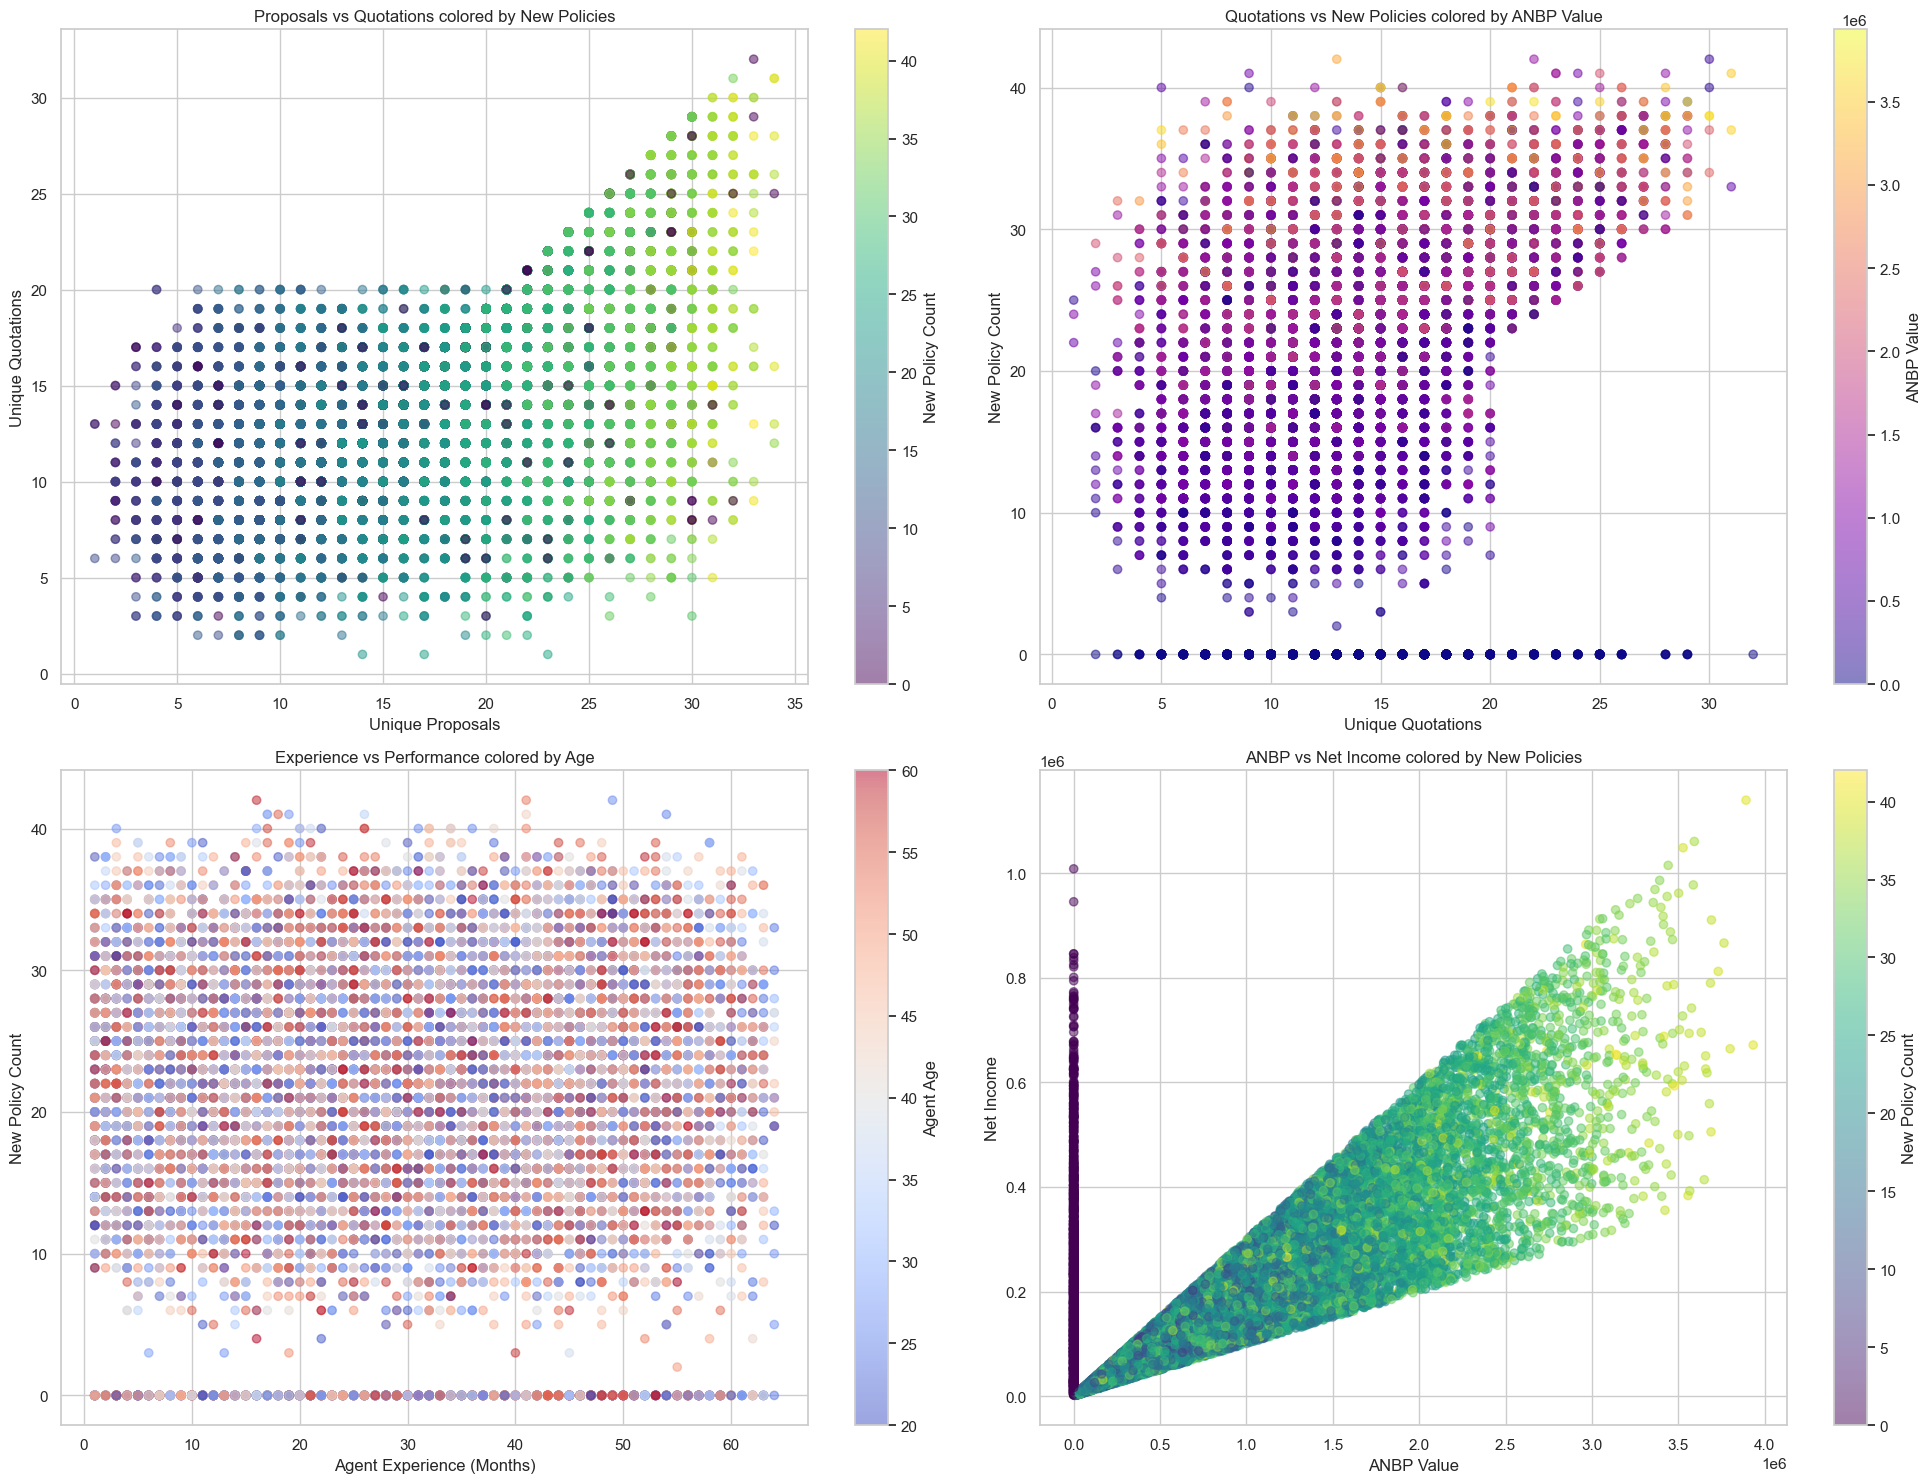

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from pandas.plotting import scatter_matrix

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")

# Load the data
train_df = pd.read_csv('train_storming_round.csv')

# Create target column as specified in the document
train_df['target_column'] = train_df['new_policy_count'].apply(lambda x: 0 if x == 0 else 1)

print(f"Shape of training data: {train_df.shape}")

# Data preprocessing and feature engineering
print("\n=== Initial Data Check ===")
print(train_df.head())

# Check for missing values
print("\n=== Missing Values ===")
print(train_df.isnull().sum())

# Convert date columns to datetime
date_columns = ['agent_join_month', 'first_policy_sold_month', 'year_month']
for col in date_columns:
    if col in train_df.columns:
        train_df[col] = pd.to_datetime(train_df[col])

# Extract additional time-based features
train_df['month'] = train_df['year_month'].dt.month
train_df['year'] = train_df['year_month'].dt.year
train_df['agent_experience_months'] = ((train_df['year_month'].dt.year - train_df['agent_join_month'].dt.year) * 12 + 
                                      (train_df['year_month'].dt.month - train_df['agent_join_month'].dt.month))
train_df['months_since_first_sale'] = ((train_df['year_month'].dt.year - train_df['first_policy_sold_month'].dt.year) * 12 + 
                                      (train_df['year_month'].dt.month - train_df['first_policy_sold_month'].dt.month))

# Replace inf values with NaN and then 0
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.fillna(0, inplace=True)

# ===================================================
# 1. Key Metrics and Distributions in the Dataset
# ===================================================
print("\n===== 1. KEY METRICS AND DISTRIBUTIONS =====")

# Summary statistics
print("\n=== Summary Statistics ===")
print(train_df.describe())

# Analyze the distribution of key metrics
numerical_cols = ['agent_age', 'unique_proposal', 'unique_quotations', 'unique_customers', 
                 'new_policy_count', 'ANBP_value', 'net_income', 
                 'number_of_policy_holders', 'number_of_cash_payment_policies']

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(train_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.grid(True)
plt.tight_layout()
plt.savefig('distributions.png')
plt.close()

# Target variable distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='target_column', data=train_df)
plt.title('Distribution of Target Variable')
plt.savefig('target_distribution.png')
plt.close()

# Key performance metrics by target
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
sns.boxplot(x='target_column', y='new_policy_count', data=train_df, ax=axes[0, 0])
axes[0, 0].set_title('New Policy Count by Target')

sns.boxplot(x='target_column', y='ANBP_value', data=train_df, ax=axes[0, 1])
axes[0, 1].set_title('ANBP Value by Target')

sns.boxplot(x='target_column', y='net_income', data=train_df, ax=axes[1, 0])
axes[1, 0].set_title('Net Income by Target')

sns.boxplot(x='target_column', y='number_of_policy_holders', data=train_df, ax=axes[1, 1])
axes[1, 1].set_title('Number of Policy Holders by Target')

plt.tight_layout()
plt.savefig('performance_by_target.png')
plt.close()

# ===================================================
# 2. Sales Patterns by Month
# ===================================================
print("\n===== 2. SALES PATTERNS BY MONTH =====")

# Aggregate monthly data
monthly_sales = train_df.groupby('year_month').agg({
    'new_policy_count': 'sum',
    'ANBP_value': 'sum',
    'net_income': 'sum',
    'agent_code': 'nunique'  # Number of active agents
}).reset_index()

monthly_sales.columns = ['month', 'total_policies', 'total_ANBP', 'total_income', 'active_agents']
monthly_sales['avg_policies_per_agent'] = monthly_sales['total_policies'] / monthly_sales['active_agents']
monthly_sales['avg_ANBP_per_agent'] = monthly_sales['total_ANBP'] / monthly_sales['active_agents']

# Plot time series for policies
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales['month'], monthly_sales['total_policies'], marker='o', linewidth=2)
plt.title('Total New Policies Over Time')
plt.xlabel('Month')
plt.ylabel('Number of New Policies')
plt.grid(True)
plt.savefig('policies_time_series.png')
plt.close()

# Plot average policies per agent
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales['month'], monthly_sales['avg_policies_per_agent'], marker='o', linewidth=2, color='green')
plt.title('Average New Policies Per Agent Over Time')
plt.xlabel('Month')
plt.ylabel('Average Policies Per Agent')
plt.grid(True)
plt.savefig('avg_policies_time_series.png')
plt.close()

# Time series decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    # Set month as index for time series analysis
    monthly_series = monthly_sales.set_index('month')
    
    # Perform decomposition
    decomposition = seasonal_decompose(monthly_series['total_policies'], model='additive', period=12)
    
    plt.figure(figsize=(16, 12))
    plt.subplot(411)
    plt.plot(decomposition.observed)
    plt.title('Observed')
    
    plt.subplot(412)
    plt.plot(decomposition.trend)
    plt.title('Trend')
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal)
    plt.title('Seasonality')
    
    plt.subplot(414)
    plt.plot(decomposition.resid)
    plt.title('Residuals')
    
    plt.tight_layout()
    plt.savefig('time_series_decomposition.png')
    plt.close()
except Exception as e:
    print(f"Time series decomposition couldn't be performed: {e}")

# ===================================================
# 3. Multivariate Analysis
# ===================================================
print("\n===== 3. MULTIVARIATE ANALYSIS =====")

# Correlation matrix of numerical features
numerical_features = ['agent_age', 'agent_experience_months', 'months_since_first_sale',
                     'unique_proposal', 'unique_quotations', 'unique_customers',
                     'new_policy_count', 'ANBP_value', 'net_income', 
                     'number_of_policy_holders', 'number_of_cash_payment_policies']

corr_matrix = train_df[numerical_features].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.close()

# Scatter plots for key related variables
plt.figure(figsize=(20, 15))

# Proposals vs Quotations vs Customers
plt.subplot(2, 2, 1)
plt.scatter(train_df['unique_proposal'], train_df['unique_quotations'], 
            alpha=0.5, c=train_df['new_policy_count'], cmap='viridis')
plt.colorbar(label='New Policy Count')
plt.xlabel('Unique Proposals')
plt.ylabel('Unique Quotations')
plt.title('Proposals vs Quotations colored by New Policies')

# Quotations vs New Policies
plt.subplot(2, 2, 2)
plt.scatter(train_df['unique_quotations'], train_df['new_policy_count'], 
            alpha=0.5, c=train_df['ANBP_value'], cmap='plasma')
plt.colorbar(label='ANBP Value')
plt.xlabel('Unique Quotations')
plt.ylabel('New Policy Count')
plt.title('Quotations vs New Policies colored by ANBP Value')

# Experience vs Performance
plt.subplot(2, 2, 3)
plt.scatter(train_df['agent_experience_months'], train_df['new_policy_count'], 
            alpha=0.5, c=train_df['agent_age'], cmap='coolwarm')
plt.colorbar(label='Agent Age')
plt.xlabel('Agent Experience (Months)')
plt.ylabel('New Policy Count')
plt.title('Experience vs Performance colored by Age')

# ANBP vs Net Income
plt.subplot(2, 2, 4)
plt.scatter(train_df['ANBP_value'], train_df['net_income'], 
            alpha=0.5, c=train_df['new_policy_count'], cmap='viridis')
plt.colorbar(label='New Policy Count')
plt.xlabel('ANBP Value')
plt.ylabel('Net Income')
plt.title('ANBP vs Net Income colored by New Policies')

plt.tight_layout()
plt.savefig('multivariate_scatter.png')

# Pairplot for key variables
key_vars = ['agent_age', 'agent_experience_months', 'unique_proposal', 
           'new_policy_count', 'ANBP_value', 'target_column']
sns.pairplot(train_df[key_vars], hue='target_column', diag_kind='kde')
plt.savefig('pairplot.png')
plt.close()

# ===================================================
# 4. Individual Agent Trajectories Over Time
# ===================================================
print("\n===== 4. INDIVIDUAL AGENT TRAJECTORIES =====")

# Select top 10 agents by total policy count for visualization
top_agents = train_df.groupby('agent_code')['new_policy_count'].sum().nlargest(10).index

# Filter data for top agents
top_agents_data = train_df[train_df['agent_code'].isin(top_agents)]

# Plot performance trajectories for top agents
plt.figure(figsize=(14, 8))
for agent in top_agents:
    agent_data = train_df[train_df['agent_code'] == agent]
    plt.plot(agent_data['year_month'], agent_data['new_policy_count'], marker='o', label=f'Agent {agent}')

plt.title('Policy Sales Trajectories for Top 10 Agents')
plt.xlabel('Month')
plt.ylabel('New Policies Sold')
plt.legend()
plt.grid(True)
plt.savefig('agent_trajectories.png')
plt.close()

# Performance profiles by agent experience
exp_groups = pd.cut(train_df['agent_experience_months'], bins=[0, 3, 6, 12, 24, 36, 100], 
                   labels=['0-3 months', '3-6 months', '6-12 months', '12-24 months', '24-36 months', '36+ months'])
train_df['experience_group'] = exp_groups

# Average performance by experience group
exp_performance = train_df.groupby('experience_group').agg({
    'new_policy_count': 'mean',
    'ANBP_value': 'mean',
    'net_income': 'mean'
}).reset_index()

# Plot performance by experience
plt.figure(figsize=(14, 7))
sns.barplot(x='experience_group', y='new_policy_count', data=exp_performance)
plt.title('Average New Policies by Agent Experience')
plt.xlabel('Experience Group')
plt.ylabel('Average New Policies')
plt.grid(True)
plt.savefig('performance_by_experience.png')
plt.close()

# ===================================================
# 5. Innovative EDA - Additional Insights
# ===================================================
print("\n===== 5. INNOVATIVE EDA - ADDITIONAL INSIGHTS =====")

# 1. Conversion ratios analysis
train_df['proposal_to_quotation_ratio'] = train_df['unique_quotations'] / train_df['unique_proposal'].replace(0, 1)
train_df['quotation_to_policy_ratio'] = train_df['new_policy_count'] / train_df['unique_quotations'].replace(0, 1)
train_df['customer_to_policy_ratio'] = train_df['new_policy_count'] / train_df['unique_customers'].replace(0, 1)

# Create a figure for conversion ratios vs performance
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(train_df['proposal_to_quotation_ratio'], train_df['ANBP_value'], alpha=0.5)
plt.title('Proposal to Quotation Conversion vs ANBP')
plt.xlabel('Proposal to Quotation Ratio')
plt.ylabel('ANBP Value')

plt.subplot(1, 3, 2)
plt.scatter(train_df['quotation_to_policy_ratio'], train_df['ANBP_value'], alpha=0.5)
plt.title('Quotation to Policy Conversion vs ANBP')
plt.xlabel('Quotation to Policy Ratio')
plt.ylabel('ANBP Value')

plt.subplot(1, 3, 3)
plt.scatter(train_df['customer_to_policy_ratio'], train_df['ANBP_value'], alpha=0.5)
plt.title('Customer to Policy Conversion vs ANBP')
plt.xlabel('Customer to Policy Ratio')
plt.ylabel('ANBP Value')

plt.tight_layout()
plt.savefig('conversion_ratios.png')
plt.close()

# 2. Recency effect - Analyzing the impact of recent activities
short_term_cols = [col for col in train_df.columns if 'last_7_days' in col]
medium_term_cols = [col for col in train_df.columns if 'last_15_days' in col]
long_term_cols = [col for col in train_df.columns if 'last_21_days' in col]

train_df['short_term_activity'] = train_df[short_term_cols].sum(axis=1)
train_df['medium_term_activity'] = train_df[medium_term_cols].sum(axis=1)
train_df['long_term_activity'] = train_df[long_term_cols].sum(axis=1)

# Plot how recency of activities impacts performance
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.regplot(x='short_term_activity', y='new_policy_count', data=train_df)
plt.title('Short Term Activity vs New Policies')

plt.subplot(1, 3, 2)
sns.regplot(x='medium_term_activity', y='new_policy_count', data=train_df)
plt.title('Medium Term Activity vs New Policies')

plt.subplot(1, 3, 3)
sns.regplot(x='long_term_activity', y='new_policy_count', data=train_df)
plt.title('Long Term Activity vs New Policies')

plt.tight_layout()
plt.savefig('recency_effect.png')
plt.close()

# 3. Analyze efficiency - ANBP per policy
train_df['value_per_policy'] = train_df['ANBP_value'] / train_df['new_policy_count'].replace(0, float('nan'))

plt.figure(figsize=(10, 6))
sns.histplot(train_df['value_per_policy'].dropna(), kde=True)
plt.title('Distribution of ANBP Value per Policy')
plt.xlabel('ANBP Value per Policy')
plt.grid(True)
plt.savefig('value_per_policy.png')
plt.close()

# 4. Agent segmentation using K-means clustering
try:
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    
    # Select features for clustering
    cluster_features = ['agent_age', 'agent_experience_months', 'unique_proposal', 
                        'unique_quotations', 'unique_customers', 'new_policy_count', 
                        'ANBP_value', 'net_income']
    
    # Get agent average metrics
    agent_metrics = train_df.groupby('agent_code')[cluster_features].mean().reset_index()
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(agent_metrics[cluster_features])
    
    # Determine optimal number of clusters using elbow method
    inertia = []
    k_range = range(1, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_data)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.savefig('elbow_method.png')
    plt.close()
    
    # Apply K-means with chosen k (let's use 4 for example)
    kmeans = KMeans(n_clusters=4, random_state=42)
    agent_metrics['cluster'] = kmeans.fit_predict(scaled_data)
    
    # Analyze clusters
    cluster_analysis = agent_metrics.groupby('cluster').mean().reset_index()
    print("\n=== Agent Cluster Analysis ===")
    print(cluster_analysis)
    
    # Visualize clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='new_policy_count', y='ANBP_value', 
                    hue='cluster', data=agent_metrics, s=100)
    plt.title('Agent Segments by Performance')
    plt.xlabel('Average New Policies')
    plt.ylabel('Average ANBP Value')
    plt.savefig('agent_clusters.png')
    plt.close()
    
except Exception as e:
    print(f"Clustering couldn't be performed: {e}")

# 5. Analyze temporal patterns in agent recruitment
plt.figure(figsize=(14, 7))
train_df['agent_join_month'].dt.to_period('M').value_counts().sort_index().plot(kind='bar')
plt.title('Agent Recruitment by Month')
plt.xlabel('Month')
plt.ylabel('Number of New Agents')
plt.grid(True)
plt.savefig('agent_recruitment.png')
plt.close()

# Calculate the time from joining to first sale for each agent
join_to_first_sale = train_df.drop_duplicates('agent_code')[['agent_code', 'agent_join_month', 'first_policy_sold_month']]
join_to_first_sale['months_to_first_sale'] = ((join_to_first_sale['first_policy_sold_month'].dt.year - 
                                            join_to_first_sale['agent_join_month'].dt.year) * 12 + 
                                            (join_to_first_sale['first_policy_sold_month'].dt.month - 
                                            join_to_first_sale['agent_join_month'].dt.month))

plt.figure(figsize=(12, 6))
sns.histplot(join_to_first_sale['months_to_first_sale'], kde=True)
plt.title('Distribution of Time to First Sale')
plt.xlabel('Months from Joining to First Sale')
plt.grid(True)
plt.savefig('time_to_first_sale.png')
plt.close()

print("\n===== EDA COMPLETE =====")
print("All visualizations have been saved as PNG files.")